In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import datetime
import pandas as pd
import numpy as np
import matplotlib as mpl
from urllib import urlretrieve
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.pylab.style.use("seaborn-muted")

In [2]:
def download_dataset(URL, dataset_name, force=False):
    """
    Utility function to download data from the server
    """
    path = "dataset/{}".format(dataset_name)
    if force or not os.path.exists(path):
        urlretrieve(URL, path)
    return path
dataset_location = download_dataset(
    URL="https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD", 
    dataset_name="FremontBridge.csv")

In [3]:
df = pd.read_csv(dataset_location, index_col="Date")
# get some stats about data
df.describe()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
count,41560.000000,41560.000000
mean,55.221824,53.991145
std,74.005863,77.915483
min,0.000000,0.000000
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,854.000000,717.000000


In [4]:
# check for null values - how many null value do we have
df.isnull().sum()

Fremont Bridge West Sidewalk    8
Fremont Bridge East Sidewalk    8
dtype: int64

In [5]:
# ignore missing values
df.dropna() 
# rename columns
df.columns = ["West", "East"]
# modify index datatype
df.index = pd.to_datetime(df.index, format="%m/%d/%Y %I:%M:%S %p")
df.head()

,West,East
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


In [6]:
# create a new calculated field
df["Total"] = df["East"] + df["West"]

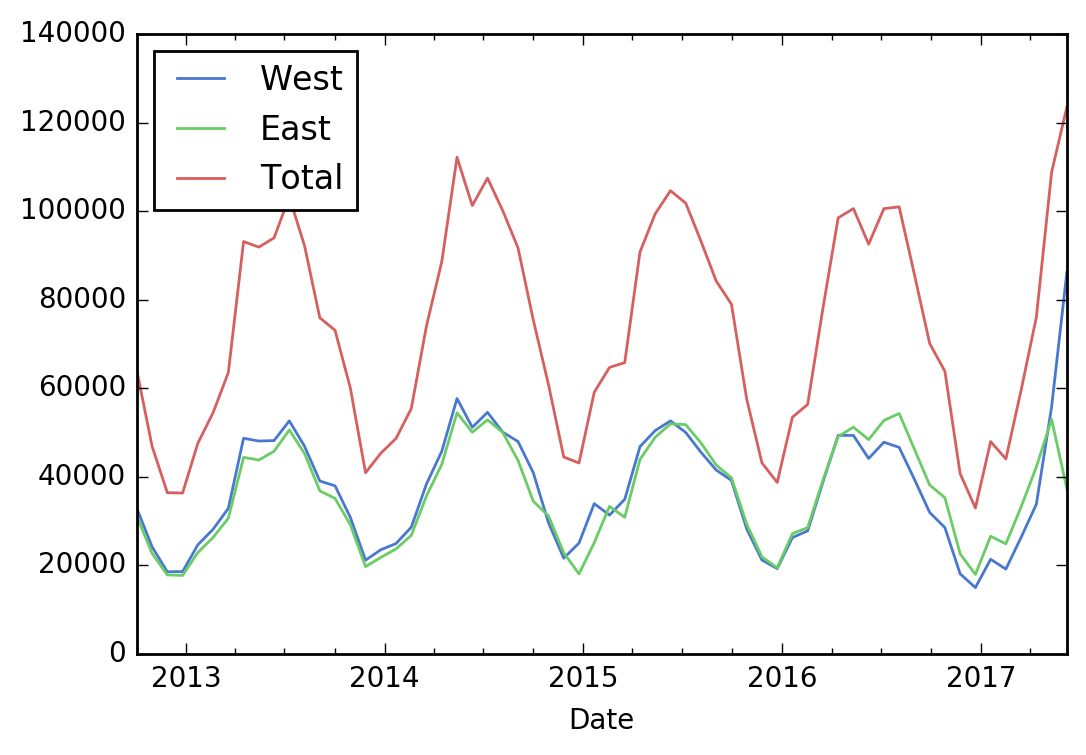

In [7]:
# see plot of sampled data
"""
Plot is showing seasonal trends along with some strong local variation
"""
df.resample("28D").sum().plot();

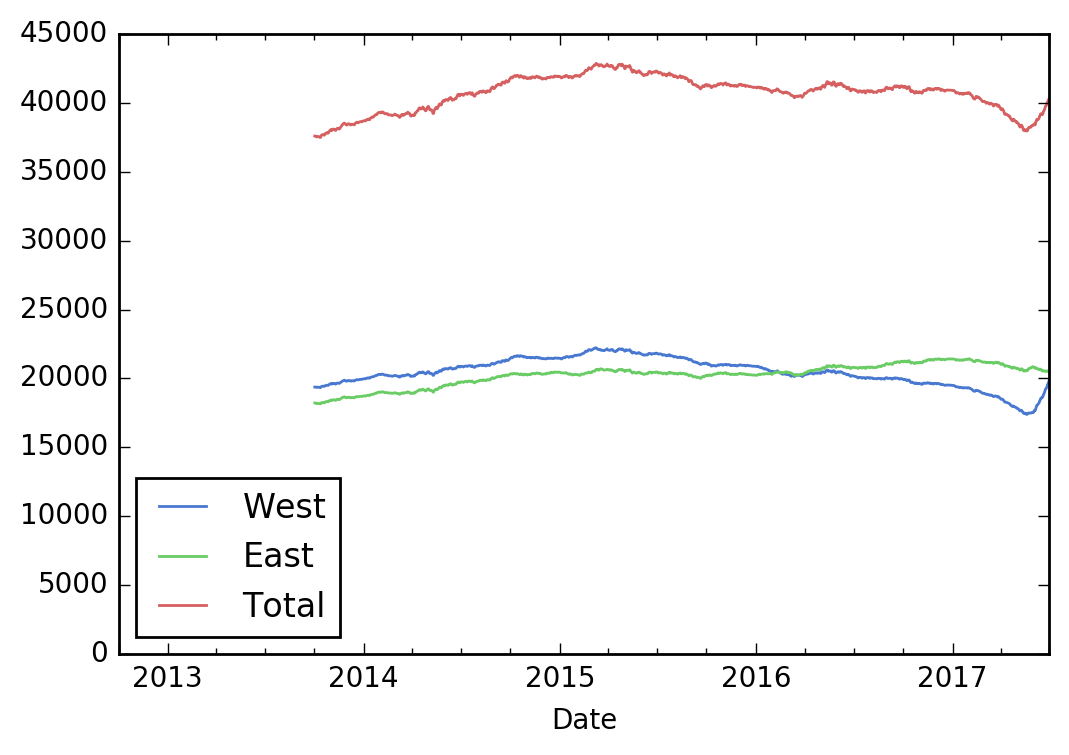

In [8]:
"""
See change in trends over time. Whether there is overall increase or there is no change etc
"""
df.resample("D").rolling(365).sum().plot()
mpl.pylab.ylim([0, None]);

In [9]:
"""
Transform data and apply machine learning to let data
speak for itself
"""
pivoted = df.pivot_table(["East", "West"], index=df.index.date, columns=df.index.hour, fill_value=0)
pivoted.head()

East                                    ... West                 \
             0  1  2  3  4   5   6    7    8    9  ...   14   15   16   17   
2012-10-03    9  6  1  3  1  10  50   95  146  104 ...   77   72  133  192   
2012-10-04   11  0  6  3  1  11  51   89  134   94 ...   63   73  114  154   
2012-10-05    7  4  3  2  2   7  37  101  119   81 ...   63   80  120  144   
2012-10-06    7  5  2  2  1   2  15   16   47   55 ...   89  115  107  107   
2012-10-07    5  5  1  2  2   3   8   12   26   36 ...  126  122  132  118   

                                     
             18  19  20  21  22  23  
2012-10-03  122  59  29  25  24   5  
2012-10-04  137  57  27  31  25  11  
2012-10-05  107  42  27  11  10  16  
2012-10-06   41  40  25  18  14  15  
2012-10-07   68  26  19  12   9   5  

[5 rows x 48 columns]

In [10]:
# shape of pivoted data
pivoted.values.shape

(1732, 48)

In [11]:
"""
reduce dimensionality of data and make sure that 90% of the
variance is still retained
"""
from sklearn.decomposition import PCA
X = pivoted.values
Xpca = PCA(0.88).fit_transform(X)
Xpca.shape

(1732, 2)

In [12]:
total_trips = X.sum(1)

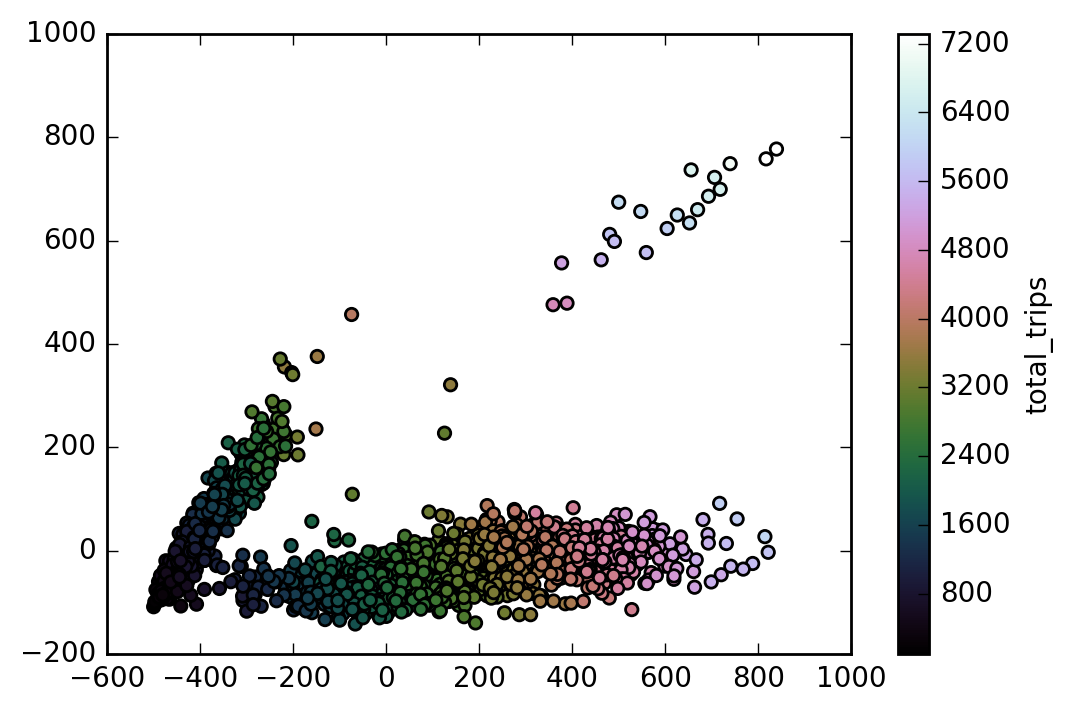

In [13]:
mpl.pyplot.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips, cmap="cubehelix")
mpl.pyplot.colorbar(label="total_trips");

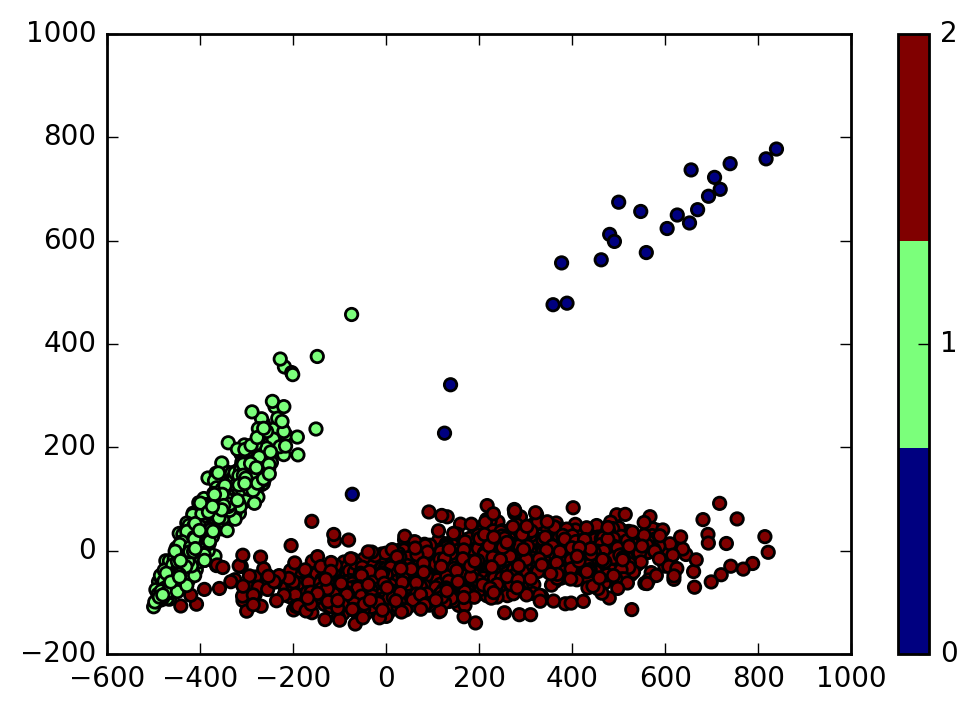

In [14]:
"""
fit gaussian mixture model and identify cluster
"""
from sklearn.mixture import GMM
gmm = GMM(3, covariance_type="full", random_state=0)
gmm.fit(Xpca)
cluster_label = gmm.predict(Xpca)
mpl.pyplot.scatter(Xpca[:, 0], Xpca[:, 1], c=cluster_label, 
                   cmap=mpl.pyplot.cm.get_cmap('jet', len(np.unique(cluster_label))))
mpl.pyplot.colorbar(ticks=np.unique(cluster_label));

In [15]:
pivoted['Cluster'] = cluster_label
df = df.join(pivoted['Cluster'], on=df.index.date)
df.head()

,West,East,Total,Cluster
Date,,,,
2012-10-03 00:00:00,4.0,9.0,13.0,2
2012-10-03 01:00:00,4.0,6.0,10.0,2
2012-10-03 02:00:00,1.0,1.0,2.0,2
2012-10-03 03:00:00,2.0,3.0,5.0,2
2012-10-03 04:00:00,6.0,1.0,7.0,2


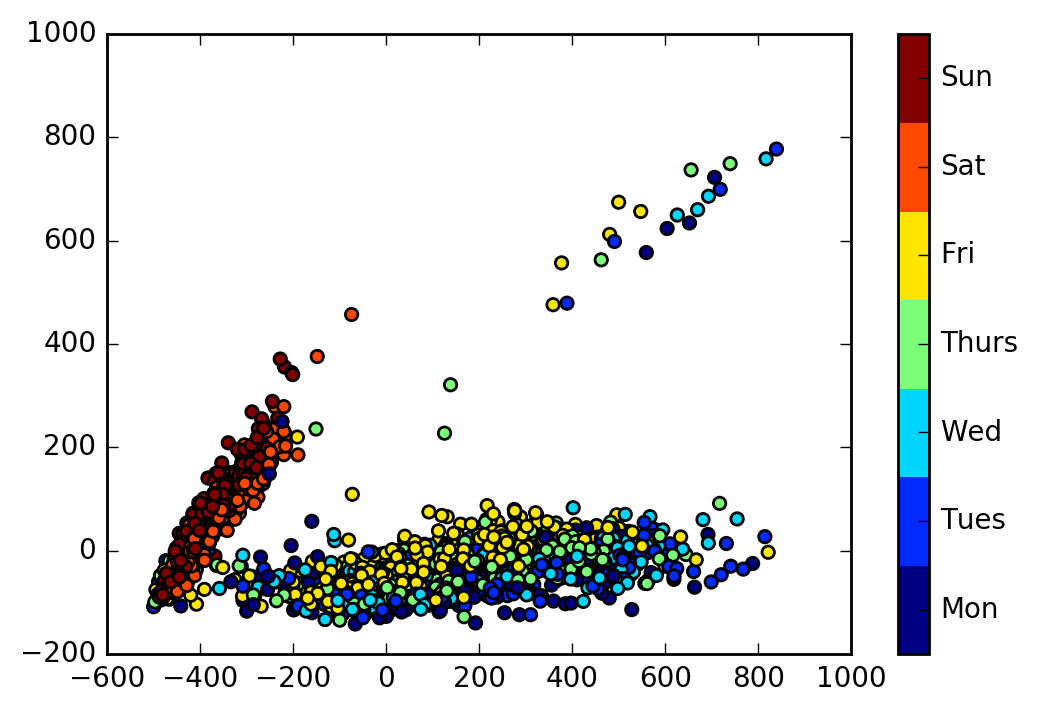

In [16]:
"""
we can clearly see two clusters first working days second weekends
"""
dayofweek = pd.to_datetime(pivoted.index).dayofweek
mpl.pyplot.scatter(Xpca[:, 0], Xpca[:, 1], c=dayofweek,
            cmap=mpl.pyplot.cm.get_cmap('jet', 7))
cb = mpl.pyplot.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
mpl.pyplot.clim(-0.5, 6.5);

In [17]:
by_hour = df.groupby(['Cluster', df.index.time]).mean()

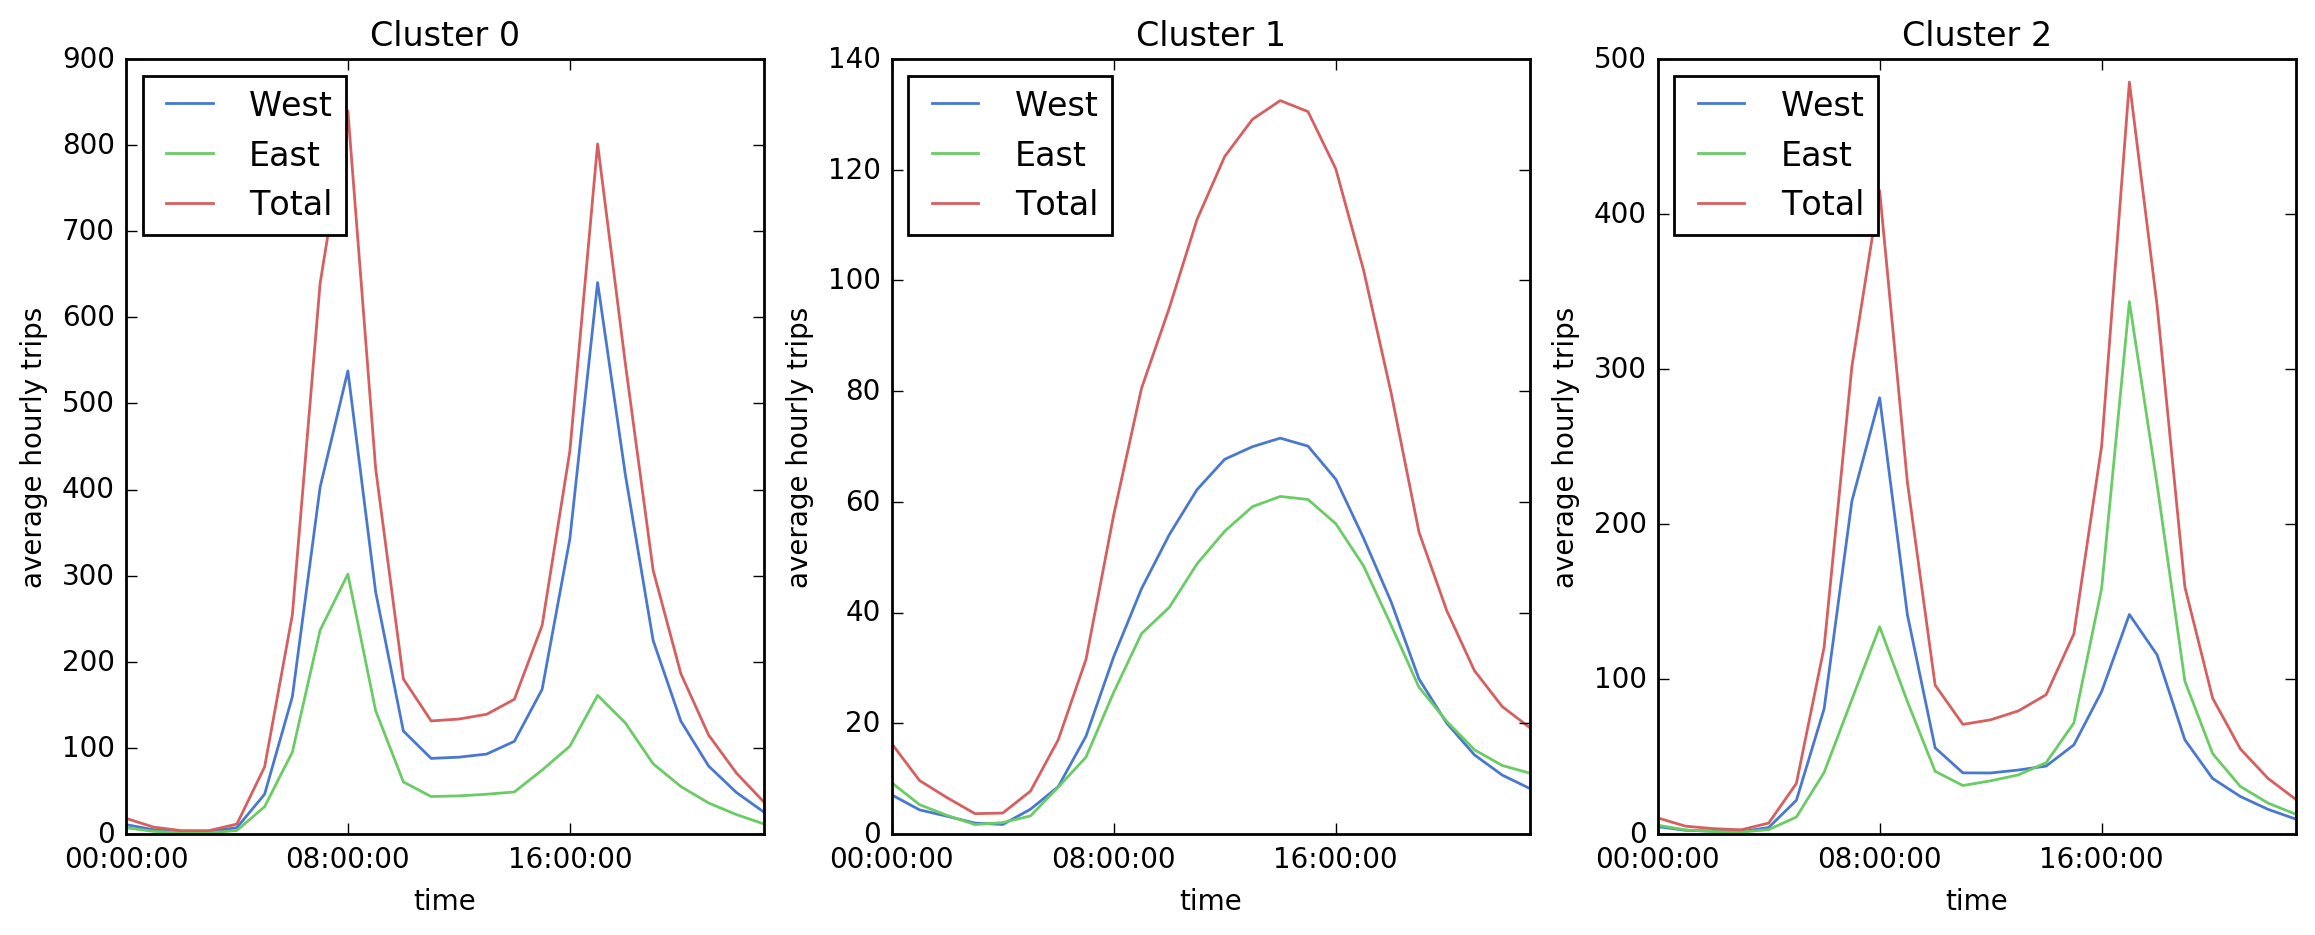

In [18]:
fig, ax = mpl.pyplot.subplots(1, 3, figsize=(14, 5))
hourly_ticks = 8 * 60 * 60 * np.arange(3)

for i in range(3):
    by_hour.ix[i].plot(ax=ax[i], xticks=hourly_ticks)
    ax[i].set_title('Cluster {0}'.format(i))
    ax[i].set_ylabel('average hourly trips')